<a href="https://colab.research.google.com/github/alexandrakraeva/IAAC2024_tutorials/blob/main/2024_chatGPT_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
!pip install openai
!pip install PyMuPDF
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.1 MB/s eta

In [ ]:
import openai
import datetime
import gradio
from openai import OpenAI
import json
from google.colab import files
import io
import fitz
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances

# API Keys

In [ ]:
# Replace 'your-api-key' with your actual API key
client = OpenAI(api_key="sk-proj-uHzSAKmW8oNpEthsd7knT3BlbkFJQUOJPSyL8PeJ1sVWi3Rd")

# Part I

## Basic ChatGPT API Call

In [ ]:
response = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=[
            {"role": "user", "content": "Tell me a the story of google in 100 words"}
        ])

In [ ]:
# lets see how the response looks like
response.dict()

In [ ]:
# lets navigate to the message/answer
answer = response.dict()["choices"][0]["message"]["content"]
answer

## How the 'chatting' part works

In [ ]:
# conversation log aka 'shortterm memory'
conversation_log = [
    {"role": "user", "content": "Hi, I am Alex. may i introduce myself? "},
    {"role": "assistant", "content": "sure, go along!"},
    {"role": "user", "content": "I i have one dog called peter and I love cooking, i have an allergy against rice, pasta and bread, and i am a big fan of cabbage"},
    {"role": "assistant", "content": "nice to meet you!"}
]

In [ ]:
input = [{"role": "user", "content": "please suggest a recipie i can cook for myself tonight"}]

response = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages= input)

In [ ]:
answer = response.dict()["choices"][0]["message"]["content"]
answer

##Two talking Bots

You can make multiple 'bots' talk to eachother simply by calling the API in a loop while maintaining the conversation_log/ shortterm memory.

In [ ]:
# wrap the API call into a function for easy re-use
def ask_chatgpt_statefull(messages, model="gpt-3.5-turbo-1106"):
    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    # Convert the response to a dictionary
    response = response.dict()

    # Accessing the content of the response
    return response['choices'][0]['message']['content']

Lets run an LLM in a loop!

In [ ]:
# initialize the conversation
conversation_log = [{"role": "user", "content": "come up with a random topic about traveling and tell a story"}]

for i in range(4):
  # call chatGPT
  description = ask_chatgpt_statefull(conversation_log)

  # add response to conversation_log in the chatgpt schema & print for review
  # Note, we add instructions for the second API call at the end
  conversation_log.append({"role": "assistant", "content":description+ ". Now ask me a why question:" })
  print("because bot: ", description, "\n__________")


 # call the chatGPT API again with the updated conversation_log
  why_question = ask_chatgpt_statefull(conversation_log)
  print("why bot: ", why_question, "\n=========")

  conversation_log.append({"role": "user", "content":why_question })

## Leveraging Language Models (LLM) for Structured Data Extraction

In practice this could mean to extract sentiment from text, emotions from images, or categorise product descriptions.

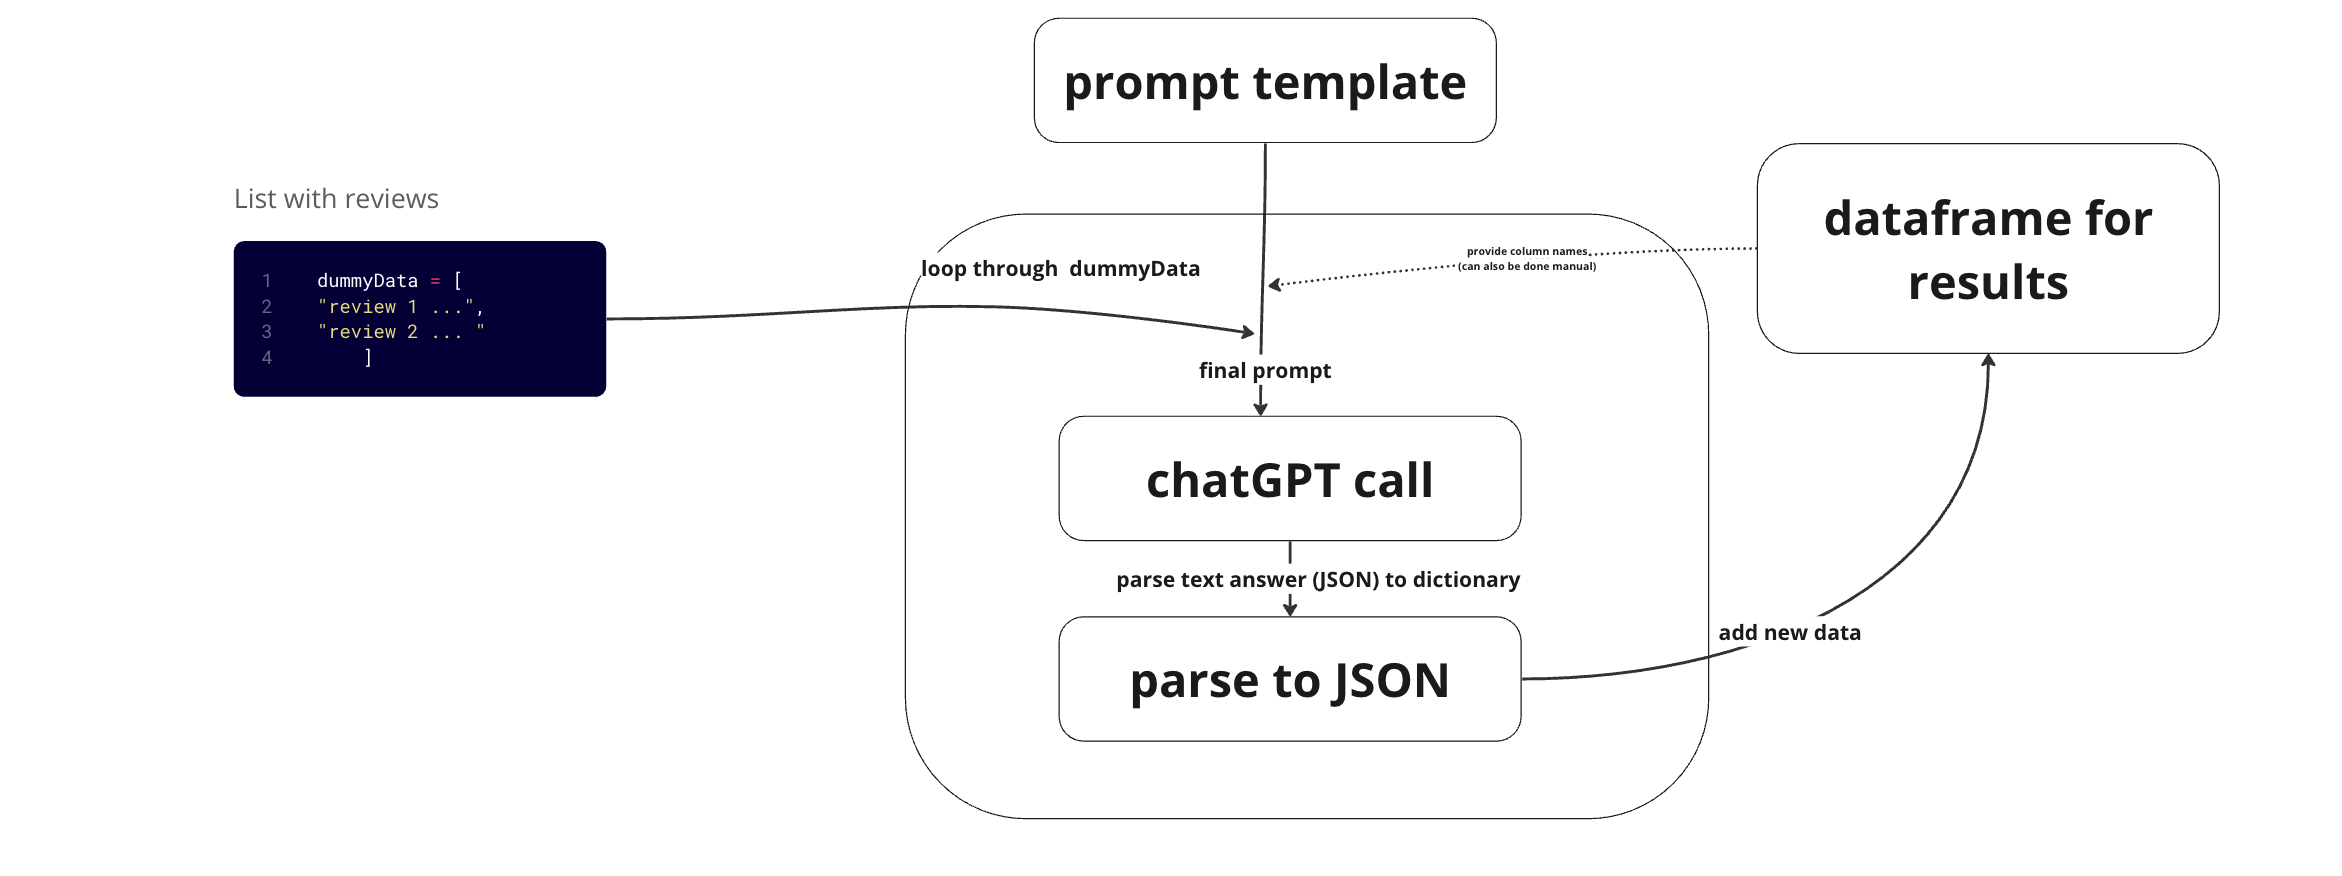

In this example we loop throuhg a list of unstructured amazon product reviews with the goal to add them to dataframe where we categorize and tag each review.

##### DummyData (a list of random amazon reviews)

In [ ]:
dummyData = [
    """1.0 out of 5 stars Overpriced, No after service Edit: I purchased cafe birraio machine which is excellent in every term.
    Thanks Amazon for great service. Seller was not able to solve problem. Returned it.
    No after sales support. No support from seller or intermediate platform. If it fails you are at your own. My machine failed in 3 months.
    Most important: If you are buying this just remember you are on your own as there is no seller support post sales and they don’t have any idea what’s going on and they don’t reply as well. So warranty looks like on papers only, and looks there will not be any support if anything happens.
    This is one of the worst performing espresso machine. Highly overpriced. Steam pressure is very low, You don’t get well frothed milk. It need a 20-25 minute break after 2 cup of coffee because it’s boiler gets over heated.
    5 people found this helpful""",
    """ 5.0 out of 5 stars Prima di lasciare questa recensione ho aspettato qualche mese per provarla bene. Devo dire che sono rimasto soddisfatto! La macchina si presenta bene dal punto di vista estetico, solida, con corpo in acciaio inox e qualche plastica, di dimensioni appropriate e non invadenti. Il macinino dopo mesi di utilizzo funziona egregiamente. Lo scaldatazze superiore è discreto. Il caffè viene estratto in maniera decisamente buona, ad una temperatura ottimale. A tal proposito consiglio, dopo l'accensione, di mettere la tazzina del caffè sotto l'erogatore in modo che si scaldi bene quando esegue il ciclo di pulizia e dopo svuotarla e rimetterla di nuovo sotto l'erogatore avviando un altro ciclo di pulizia: noterete che questa volta l'acqua esce con sbuffi di vapore ed in maniera meno regolare; da questo momento in poi ad ogni erogazione di acqua questa esce regolarmente ed in maniera appropriata per un'estrazione ottimale del caffè. Consiglio questa manovra ad ogni nuova accensione della macchina. Ho letto in alcune recensioni che è stato notato un difetto di erogazione quando si preparano 2 caffè, nel senso che uscirebbe maggiormente dall'ugello di sinistra: nel mio caso questo non è mai accaduto come potete notare dal video allegato. A questo proposito consiglierei di valutare con attenzione la collocazione della macchina perfettamente in piano e, soprattutto, prima di effettuare la pressatura di utilizzare un distributore di caffè che consenta di livellarlo nel portafiltro in maniera ottimale per l'estrazione. Per quanto riguarda il montalatte lo trovo buono anche se non eccelso. Il filtro addolcitore dopo 2 mesi di utilizzo l'ho sostituito con un filtro DLSC002 marca Queta (acquistato sempre su Amazon), che alla prova funziona egregiamente e si adatta alla macchina meglio di quello in dotazione che probabilmente era un De Longhi originale ma che sembrava meno stabile e in più costa molto meno della metà. Attenzione perché nella descrizione del filtro non viene mai citata la compatibilità con la macchina Ariete 1313 e questo potrebbe far desistere dall'acquisto ed anch'io ero un po' titubante, ma avendo notato nella descrizione che le misure del filtro combaciavano con quello in dotazione mi sono deciso ad acquistarlo. Un'ultima considerazione per la riuscita ottimale di un buon caffè è di provare la miscela in grani che più si adatta al vostro gusto e di sperimentare per ogni miscela il giusto grado di macinazione, la giusta quantità di acqua da programmare per l'erogazione e la giusta quantità di caffè da caricare nel filtro: possono sembrare banalità ma vi assicuro che sono fondamentali. All'inizio bisogna sperimentare e poi una volta trovato il giusto equilibrio diventa tutto meccanico e semplice. Alla luce anche del fattore prezzo (ho acquistato la macchina in offerta pagandola intorno ai 250 euro) direi che è un ottimo acquisto e la consiglio.
    Read less
    12 people found this helpful""",
    """5.0 out of 5 stars Zuverlässige und erschwingliche Bleistifte für den alltäglichen Gebrauch
    Reviewed in Germany on 5 October 2023
    Size Name: 1 stück (30er Pack)Verified Purchase
    Ich habe vor kurzem die Amazon Basics holzgefassten Bleistifte gekauft und möchte meine Erfahrungen mitteilen.
    Die Bleistifte bestehen aus hochwertigem Holz und haben eine angenehme Haptik. Sie liegen gut in der Hand und sind leicht zu handhaben. Die Mine ist mittelhart und ermöglicht ein präzises Schreiben und Zeichnen. Die Bleistifte lassen sich leicht spitzen und die Mine bricht nicht leicht ab.
    Die Haltbarkeit der Bleistifte ist beeindruckend. Trotz des täglichen Gebrauchs halten sie erstaunlich lange. Ich habe bereits zahlreiche Seiten mit ihnen gefüllt und sie funktionieren immer noch einwandfrei.
    Ein weiterer Vorteil ist der angebrachte Radiergummi. Er ist von guter Qualität und ermöglicht ein einfaches Radieren von Fehlern und Korrekturen. Die Radierer hinterlassen keine unschönen Spuren auf dem Papier und sind ausreichend groß.
    Die Verpackung der Bleistifte ist einfach und zweckmäßig. Sie kommen in einer einfachen Plastikhülle, die die Bleistifte schützt und sicher aufbewahrt.
    Der Preis der Amazon Basics holzgefassten Bleistifte ist unschlagbar. Sie bieten ein ausgezeichnetes Preis-Leistungs-Verhältnis, insbesondere wenn man bedenkt, dass es sich um ein Set von 30 Bleistiften handelt.
    Ob für den Schulgebrauch, das Büro oder den alltäglichen Gebrauch zu Hause - die Amazon Basics holzgefassten Bleistifte sind eine zuverlässige Wahl. Sie bieten eine solide Leistung und sind erschwinglich. Ich kann diese Bleistifte jedem empfehlen, der eine kostengünstige Option für den täglichen Gebrauch sucht und dabei nicht auf Qualität verzichten möchte.
    Read less
    5 people found this helpful""",
    """5.0 out of 5 stars Top Lampe! Perfekt.Reviewed in Germany on 27 April 2024
    Verified Purchas Wirklich toll diese Lampe. Habe schon die zweite davon gekauft. Gute Helligkeit. Diverse Farbmodi. Leicht zu installieren (geht fast automatisch, WLAN etc.). Durch die App hat man immer alles unter Kontrolle. Gut, die Optik der Lampe ist nicht so ganz stylisch. Das könnte man anders designen, aber gut. Sie tut, was sie soll. Kleiner Kritikpunkt: In der App müsste man direkt sehen, ob die Lamp bereits eingeschaltet ist (ähnlich wie bei FRITZ! von AVM). Da ist der Regler dann grün. Hier muss man erst in der App in die Oberfläche der Lampe klicken. Aber das ist nur ein kleiner Punkt. Sonst kann ich sie nur empfehlen."""
]

##### Code

1. Create a Dataframe to collect information extracted from the reviews

In [ ]:
# lets initialize a dataframe with the columns
# named after information we are intereded in
columnNames = ["productCategory", "reviewSentiment", "reviewSummaryEnglish"]
dataCollection = pd.DataFrame(columns = columnNames)

2. (optional) Trun the empty dataframe into a dictionary and then into a JSON string. We can use that string to tell the LLM how we want the answer to be structured!

In [ ]:
# dataframe ->  dictionary -> text string
data_dict = dataCollection.to_dict(orient='list')
data_dict_json = json.dumps(data_dict).replace("[]", '""')

# lets take a look at the resulting string
data_dict_json

'{"productCategory": "", "reviewSentiment": "", "reviewSummaryEnglish": ""}'

3. Assemble the prompt-template

In [ ]:
# this might get a bit longer
prompt_template = f"""
Your task is to analyse the product reviews from a webplatform you will see below. You should try
your best to determine infomration on these subjects {str(columnNames)}.

Please return you answer in the structure of a JSON. DO not add any comment or
thouhgts, only aswer with the json. Below is an example of how the JSON shall be
formated: {data_dict_json}.

the review text:
"""

4.  loop through the list of dummyData
*   construct the final prompt
*   call the LLM
*   parse the JSON part to a dict
*   add to dataCollection

In [ ]:
for review in dummyData:

  # construct final prompt
  final_prompt = prompt_template + review
  #print ("final prompt: ", final_prompt)

  # call the LLM, navigate to answer message
  response = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=[
            {"role": "user", "content": final_prompt}
        ])


  answer = response.dict()["choices"][0]["message"]["content"]
  print("answer: ", answer)

  # parse the JSON part (might fail if llm makes a mistake)
  answer_dict = json.loads(answer)
  answer_df =  pd.DataFrame(answer_dict, index=[0])

  # add to dataframe
  dataCollection = pd.concat([dataCollection, answer_df], ignore_index=True)


In [ ]:
# lets see the result
dataCollection

# Part II

## chatGPT Vision

### utilities


In [ ]:
from PIL import Image # python libary for image processing
from io import BytesIO
import base64

In [ ]:
# turning an image to its b64 encoding (-> sending it as text)
def image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")  # You can change the format to PNG or other types if needed
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return img_str

### main part

In [ ]:
# upload image and transform to PIL format
uploaded_img_vis = files.upload()
filename = next(iter(uploaded_img_vis))
image_vis = Image.open(BytesIO(uploaded_img_vis[filename]))

Saving IMG_20230903_164035.jpg to IMG_20230903_164035.jpg


In [ ]:
def gpt_vision(vision_prompt, image_encoded):
  response = client.chat.completions.create(
      model="gpt-4-vision-preview",
      messages=[
          {
            "role": "user",
            "content": [
              {"type": "text", "text": vision_prompt},
              { "type": "image_url",
                "image_url": {
                  "url": "data:image/jpeg;base64,"+ image_encoded,
                },
              },
            ],
          },
        ],
        max_tokens=800,
  )
  return response.choices[0].message.content

In [ ]:
base64_image = image_to_base64(image_vis)

In [ ]:
img_desc = gpt_vision("where do you think was the image taken? try to analyse all aspects? then rank a few potential locations ", base64_image)

## TASK I: create a gptVision App
Brainstorm a idea for an simple gradio app utilizing gpt and gptVision

In [ ]:
global gptVisionAppPromptTemplate
gptVisionAppPromptTemplate = """
Here is an image, try to count the number of glasses or cups on the image.
 """

In [ ]:
def gptVisionApp(prompt, image):
  # encode to b64
  image_encoded = image_to_base64(image)

  global gptVisionAppPromptTemplate
  final_prompt = gptVisionAppPromptTemplate + prompt

  res = gpt_vision(final_prompt,image_encoded)

  return res


In [ ]:
# Gradio interface setup
iface = gradio.Interface(
    fn=gptVisionApp,
    inputs=[
        gradio.Textbox(label="Optional Text Prompt"),
        gradio.Image(type="pil", label="Upload Image" ),
    ],
    outputs=[
        gradio.Textbox(label="Output from ChatGPT Vision"),
    ],
    title="your app title",
    description="Upload an image and optionally add text to get a response from the ChatGPT Vision model."
)

# Run the interface
iface.launch(debug = True, share=True)

### gptVision App example

In [ ]:
from pathlib import Path
import tempfile

In [ ]:
global gptVisionAppPromptTemplate
gptVisionAppPromptTemplate = """
your job is to analyse the provided image and search for any posters, webistes
visible or others that indicate an event. Carefully analyse text and visual clues.
Then, generate an .ics file following the .ics format similar to the example
show cased between the '''':
''''
BEGIN:VCALENDAR
VERSION:2.0
PRODID:-//Your Company//Your Product//EN
BEGIN:VEVENT
UID:20230506T120000-1234@example.com
DTSTAMP:20230506T120000Z
ORGANIZER;CN=Example Organizer:mailto:organizer@example.com
DTSTART:20230510T140000Z
DTEND:20230510T150000Z
SUMMARY:Example Event
DESCRIPTION:This is an example description for an example event.
LOCATION:123 Example Street, Example City, EX
STATUS:CONFIRMED
SEQUENCE:0
BEGIN:VALARM
TRIGGER:-PT10M
ACTION:DISPLAY
DESCRIPTION:Reminder
END:VALARM
END:VEVENT
END:VCALENDAR
''''

Only anwser with a valud .ics, do not add anything else, no comments or thoughs only
a valud .ics


 """

In [ ]:
def gptVisionApp(prompt, image):
    # Assuming `image_to_base64` and `gpt_vision` are defined elsewhere
    image_encoded = image_to_base64(image)  # Convert image to base64 encoded string

    global gptVisionAppPromptTemplate
    final_prompt = gptVisionAppPromptTemplate + prompt

    res = gpt_vision(final_prompt, image_encoded)  # Assume this returns a string response
    res = str(res)  # Ensure response is string

    # Write output to a temporary .ics file
    temp_dir = tempfile.gettempdir()
    temp_file_path = Path(temp_dir) / "output.ics"
    with open(temp_file_path, "w") as file:
        file.write(res)

    # Return the path to the temporary file
    return res, str(temp_file_path)

In [ ]:
# Gradio interface setup
iface = gradio.Interface(
    fn=gptVisionApp,
    inputs=[
        gradio.Textbox(label="Optional Text Prompt"),
        gradio.Image(type="pil", label="Upload Image"),
    ],
    outputs=[
        gradio.Textbox(label="Output from ChatGPT Vision"),
        gradio.DownloadButton(label="Download Output as .ics File"),  # Correct use of DownloadButton
    ],
    title="Your App Title",
    description="Upload an image and optionally add text to get a response from the ChatGPT Vision model."
)

# Run the interface
iface.launch(debug = True, share=True)

# Part III

## Use LLM's to controll function parameter

In [ ]:
def callGPT(messages, model="gpt-3.5-turbo-1106"):
    response = client.chat.completions.create(
        model=model,
        #response_format={"type": "json_object"},
        messages=[{"role": "user", "content": messages}],
    )
    return response.choices[0].message.dict()

In [ ]:
user_prompt = "whats the time right now?"


response = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=[{"role": "user", "content": user_prompt}],
    )
response.choices[0].message.dict()["content"]


"I'm sorry, I cannot provide the current time as I do not have that capability."

Lets create a setup

In [ ]:
def callGPT(messages, model="gpt-3.5-turbo-1106"):
    response = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=[{"role": "user", "content": messages}],
    )
    return response.choices[0].message.dict()

In [ ]:
# lets create a function to check the time!
def getTime(time_type):
  # return day time or date
  now = datetime.datetime.now()
  if time_type.lower() == "day_time":
      return now.strftime("%H:%M:%S")
  elif time_type.lower() == "date":
      return now.strftime("%Y-%m-%d")

In [ ]:
prompt_template = """
You are a helpfull assistant. Try your best to fullfill the user query. To empower
you further you can use the "getTime" tool. in oder to use it answer in the following
JSON format:

{"message":"your regular message to  the user",
"tool":"getTime"
"args":{"time_type":"date"}
}

if you dont need to use the tool only leve "tool" and "args" empty. If you use the tool
use the message field to explain your argument choices.
The argument time_type can either be "date" (to get the current y:m:d) or
day_time to the the current time (h:m:s).

Ensure to always answer in exactly that json fomrat. Do not add any comments or thoughts.
Below is the user query:
"""

In [ ]:
user_prompt = "is it afternoon right now?"

In [ ]:
final_prompt = prompt_template + user_prompt
res = callGPT(final_prompt)

resdict = json.loads(res["content"])

Lets bring it all together:

In [ ]:
# lets use the arguments to actually call the function
final_prompt = prompt_template + user_prompt
res = callGPT(final_prompt)

resdict = json.loads(res["content"])
print (resdict)
if resdict["tool"] == "getTime":
  timeType = resdict["args"]["time_type"]
  curTime = getTime(timeType)
  print(timeType)

  # conduct second API call to provide the user with the complete anwser
  promptWithData = f"""This is the result of using the getTime tool with the
  argument <{timeType}>: <{curTime}>. Use the infromation to answer the user query:
  {user_prompt}
  """

  finalRes = callGPT(promptWithData)
  print ("final outcome: ", finalRes["content"])

## TASK II: Add natural language controll spatial analysis

Based on the examples above and previous classess on osmnx and networkx.

see Stasyas Notebook: https://colab.research.google.com/github/STASYA00/IAAC2024_tutorials/blob/main/quickstarts/02_osm_data.ipynb#scrollTo=-7vrUW-fOsRT

In [ ]:
# additional imports
!pip install osmnx geopy scikit-learn
import geopandas
import matplotlib.pyplot as plt
import osmnx
import seaborn as sns
from shapely.geometry import Point, LineString

In [ ]:
PLACE_NAME = "el Poblenou, Barcelona, Spain"

In [ ]:
# data preperation
graph = osmnx.graph_from_place(PLACE_NAME)
nodes, edges = osmnx.graph_to_gdfs(graph)
buildings = osmnx.geometries_from_place(
    PLACE_NAME,
    {"building": True},
)
restaurants = osmnx.geometries_from_place(
    PLACE_NAME,
    {
        "amenity": "restaurant"
    }
)

<ipython-input-322-0fa3a95aab7b>:4: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings = osmnx.geometries_from_place(
<ipython-input-322-0fa3a95aab7b>:8: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  restaurants = osmnx.geometries_from_place(


In [ ]:
def geocode(our_places, provider="nominatim",user_agent="autogis2023",timeout=10):
  geocoded_addresses = geopandas.tools.geocode(
      our_places,
      provider=provider,
      user_agent=user_agent,
      timeout=timeout
    )

  return geocoded_addresses

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


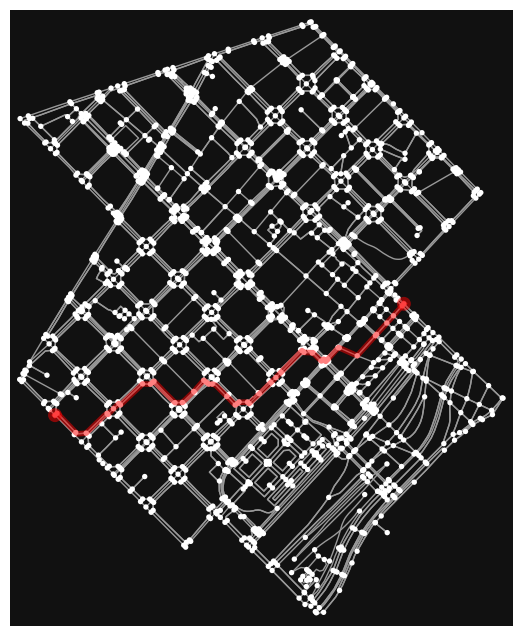

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
origin = (
    osmnx.geocode_to_gdf("Institute for Advanced Architecture of Catalonia")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    osmnx.geocode_to_gdf("Jardins de l'Arenal de Llevant")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)

# calculating the shortest path:
route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)

# plotting the projection
fig, ax = osmnx.plot_graph_route(graph, route)

## Function Calling

The chatGPT API comes with a utility feature that makes it easier to generate parameter for needed to call e.g. python functions. The LLM is not calling any function itself, instead it can generate input parameter we can the manually pass to the function

1. Set-up base function to call chatGPT using its function calling cpability

In [ ]:
def callGPT(prompt, model="gpt-3.5-turbo-1106"):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content":messages}],
        tools=tools,
        tool_choice=tool_choice
    )
    return response.choices[0].message.dict()

Lets test it:

In [ ]:
conversation = [{"role": "user", "content": "what is the time right now?"}]

res = callGPT(conversation)
res["content"]

"I'm sorry, I am just a virtual assistant and do not have the capability to provide real-time information such as the current time. I recommend checking your device or a reliable source for the current time."

2. Define a list of available 'tools'

In [ ]:
# lets create a function to check the time!
def getTime(time_type):
  # return day time or date
  now = datetime.datetime.now()
  if time_type.lower() == "time":
      return now.strftime("%H:%M:%S")
  elif time_type.lower() == "date":
      return now.strftime("%Y-%m-%d")

In [ ]:
# define 'tools' using the schema defined by openAI
# more infos:
tools = []
tools.append({
        "type": "function",
        "function": {
            "name": "getTime",
            "description": "gets the current day time (time) or date (month, day, year)",
            "parameters": {
                "type": "object",
                "properties": {
                    "time_type": {
                        "type": "string",
                        "enum": ["date", "time"]},
                },
                "required": ["time_type"],
            },
        },
    })

In [ ]:
# lets try this again with tools enabled
conversation = [{"role": "user", "content": "what is the time right now?"}]
res = callGPT(conversation, tools =tools)
res


{'content': None,
 'role': 'assistant',
 'function_call': None,
 'tool_calls': [{'id': 'call_Y93bV9uUYimN7lFrMyDD7uHL',
   'function': {'arguments': '{"time_type": "time"}', 'name': 'getTime'},
   'type': 'function'},
  {'id': 'call_csgGe4Vo4itjMfz9EJYKmeJh',
   'function': {'arguments': '{"time_type": "date"}', 'name': 'getTime'},
   'type': 'function'}]}

In [ ]:
functionName = res["tool_calls"][0]["function"]["name"]
functionArgs = json.loads(res["tool_calls"][0]["function"]["arguments"])

# lets call the time function
if functionName == "getTime":
  curTime = getTime(functionArgs["time_type"])
  print(curTime)


22:52:48


Note: the LLM only returned the argument for the function it aimed to call. If we want to use the information to answer the users question we need to add the functionr esult back to our conversation.  Ther is a specific systax/schema for that:

In [ ]:
def toolResultFormater(gpt_message, function_result, tool_call_id = 0):
  tool_result = {"role": "tool",
                  "tool_call_id": gpt_message["tool_calls"][tool_call_id]["id"],
                  "name": gpt_message["tool_calls"][tool_call_id]["function"]["name"],
                  "content": function_result
                 }
  # construct a message logging the event of the tool call
  gpt_message["content"] = str(gpt_message["tool_calls"][tool_call_id]["function"])
  del gpt_message["function_call"]

  return tool_result, gpt_message


In [ ]:
# lets try this again with tools enabled
conversation = [{"role": "user", "content": "is it afternoon right now?"}]

res = callGPT(conversation, tools =tools)
print (res)
functionName = res["tool_calls"][0]["function"]["name"]
functionArgs = json.loads(res["tool_calls"][0]["function"]["arguments"])

# lets call the time function
if functionName == "getTime":
  curTime = getTime(functionArgs["time_type"])

  # format the result from using the 'tool' for chatGPT
  formated_tool_result, ass = toolResultFormater(res, curTime)
  print (formated_tool_result)

  # add to conversation:
  conversation.append(ass)
  conversation.append(formated_tool_result)

print(conversation)
res = callGPT(conversation, tools =tools)




{'content': None, 'role': 'assistant', 'function_call': None, 'tool_calls': [{'id': 'call_iCP5ShTLZEBYv2VzLFUUG6dQ', 'function': {'arguments': '{"time_type":"time"}', 'name': 'getTime'}, 'type': 'function'}]}
{'role': 'tool', 'tool_call_id': 'call_iCP5ShTLZEBYv2VzLFUUG6dQ', 'name': 'getTime', 'content': '23:07:58'}
[{'role': 'user', 'content': 'is it afternoon right now?'}, {'content': '{\'arguments\': \'{"time_type":"time"}\', \'name\': \'getTime\'}', 'role': 'assistant', 'tool_calls': [{'id': 'call_iCP5ShTLZEBYv2VzLFUUG6dQ', 'function': {'arguments': '{"time_type":"time"}', 'name': 'getTime'}, 'type': 'function'}]}, {'role': 'tool', 'tool_call_id': 'call_iCP5ShTLZEBYv2VzLFUUG6dQ', 'name': 'getTime', 'content': '23:07:58'}]


In [ ]:
res

{'content': 'It is currently 23:07:58, which is evening.',
 'role': 'assistant',
 'function_call': None,
 'tool_calls': None}

In [ ]:
# define 'tools' using the schema defined by openAI
# more infos:

tools = []

tools.append({
        "type": "function",
        "function": {
            "name": "function_name",
            "description": "describe_your_function_so_the_llm_knows_what_it_does",
            "parameters": {
                "type": "object",
                "properties": {
                    "parameterA": {
                        "type": "string",
                        "description": "describe what kind of values are expected",
                    },
                    "parameterB": {
                        "type": "string",
                        "enum": ["list", "of", "values", "to","choose", "from"]},
                },
                "required": ["parameterA"],
            },
        },
    })

# you can add multiple of such 'tools' !

In [ ]:
args = json.loads(response.tool_calls[0].function.arguments)